# Falling ball - A Multimesh Motivation


This notebook contains an comparasion of a single-mesh and multimesh approach for a falling ball in a vent.
We start by importing the packages needed.

In [1]:
from dolfin import *
import matplotlib.pyplot as plt
from .Poisson_comparasion.create_multiple_meshes.py import front_mesh

ModuleNotFoundError: No module named '__main__.Poisson_comparasion'; '__main__' is not a package

We then create a single mesh, describing a ball in a well, with *gmsh*, and convert it to dolfin with *dolfin-convert*. Thereafter, we load in face data, that gives distinct values to the boundary describing the well, and the ball. The distinct values are visualized with circles.

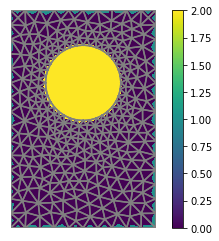

In [2]:
os.system("gmsh -2 multimesh_back.geo")
os.system("dolfin-convert multimesh_back.msh sm.xml")
mesh = Mesh("sm.xml")
facets = MeshFunction("size_t", mesh, "sm_facet_region.xml")
%matplotlib inline
fig, ax = plt.subplots(1,1)
plot(mesh)
plt.axis([0,2,0,3])
ax.set_frame_on(False)
ax.set_xticks([]); ax.set_yticks([])
#ax.set_xlabel('T=0',size=20)
plt.savefig("SM_org.eps", bbox_inches="tight")
facet_plot2d(facets, kind="heatmap")
plt.show()

Thereafter, we create a function describing the forces (gravity) that is present. To only create a vector field that
is non-zero on the ball, we use a *DirichletBc*.

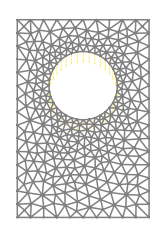

(0.7558041666379998, 0.9999886992694227)


In [4]:
V = VectorFunctionSpace(mesh, "CG", 1)
v = Function(V)
d = interpolate(Expression(("0","-0.02"), degree=2), V)
b = DirichletBC(V, d, facets, 2)
b.apply(v.vector())
fig, ax = plt.subplots(1,1)
plot(mesh)
plot(v,scale=0.25)
ax.set_frame_on(False)
ax.set_xticks([]); ax.set_yticks([])
# ax.set_xlabel('T=0',size=20)
plt.show()
print(MeshQuality.radius_ratio_min_max(mesh))

We use the Toolbox [FEMORPH](https://bitbucket.org/Epoxid/femorph) for mesh-deformation. Specifically, we use a [Two-stage Eikonal Convection-Diffusion equation](https://arxiv.org/abs/1411.7663) to deform the mesh. We use a version that has been slightly modified, available at [**_BitBucket/dokken_**](https://bitbucket.org/dokken/literature-review/src/4b163aa2ad496536916a079d291e33be7fe51767/code/Illustration_intro/?at=master)

In [5]:
from femorph import *
from femorph.Legacy import *

Then, let the ball fall (Be patient, this will takes quite some time)

<IPython.core.display.Javascript object>


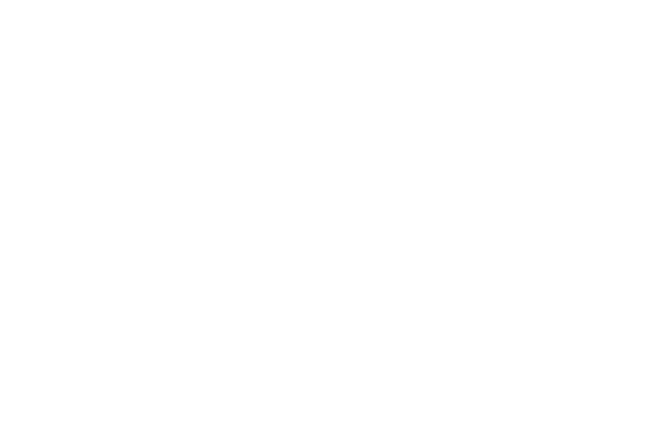

RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve nonlinear system with NewtonSolver.
*** Reason:  Newton solver did not converge because maximum number of iterations reached.
*** Where:   This error was encountered inside NewtonSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2018.2.0.dev0
*** Git changeset:  bec9fa53e5900a0dce28653cf193db5fac58255e
*** -------------------------------------------------------------------------


<IPython.core.display.Javascript object>


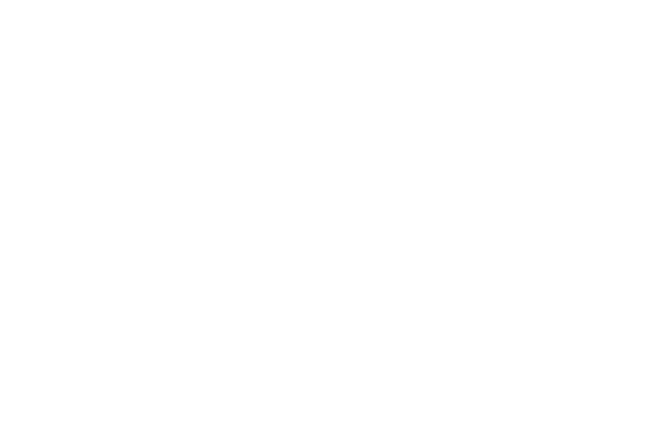

In [8]:
%matplotlib notebook
fig = plt.figure()
N = 50
for i in range(N):
    w1 = ConvectionDeformation(mesh, facets, v,
                                                VariableIDs=[2],
                                                FixedIDs=[1], Diffusion=1e-1)
    ALE.move(mesh, w1)    
    (L1B, L2B,fix_deform)=DiscreteMeshRepair(mesh, facets, True, True, True,
                                             VolumeNormal(mesh),
                                             MaxIter = 1, Step = 1.0,
                                             Stop = 1e-6,
                                             FixPlanes = [])
    ALE.move(mesh, fix_deform)
    plt.cla()
    plt.axis([0,2,0,3])
    plt.title("Iteration: %d" %i)
    plot(mesh)
    fig.canvas.draw()
    print(MeshQuality.radius_ratio_min_max(mesh))

We save the final resolution as a vector graphic

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(1,1)
plot(mesh)
plt.axis([0,2,0,3])
ax.set_frame_on(False)
ax.set_xticks([]); ax.set_yticks([])
# ax.set_xlabel('T=1',size=20)
plt.savefig("SM_fin.eps",bbox_inches='tight')
plt.close()

As we can observe from the images above, the mesh degenerates with large movements, and the mesh-deformation is time-consuming.
We therefore introduce another way of representing the ball, namely with **Multiple meshes**.
We import two different meshes, a stationary background mesh, and a mesh decribing the ball.
We indicate the boundary of the ball with red circles


In [ ]:
%matplotlib notebook
backgroundmesh = RectangleMesh(Point(0,0),Point(2,3), 10,15)
os.system("gmsh -2 multimesh_front.geo")
os.system("dolfin-convert multimesh_front.msh front.xml")
front = Mesh("front.xml")
facets_front = MeshFunction("size_t", front, "front_facet_region.xml")
plt.figure()
plt.subplot(1,2,1)
plot(backgroundmesh)
plt.subplot(1,2,2)
plot(front,color="k")
facet_plot_edge(facets_front,front, markers=[2])
plt.axis([0,2,0,3])

We save the MultiMesh as an svg-file

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
ax.axis([0,2,0,3])
ax.set_frame_on(False)
ax.set_xticks([]); ax.set_yticks([])
# ax.set_xlabel('T=0',size=20)
plot(backgroundmesh, backend="matplotlib")
plot(front, backend="matplotlib",color='k')
import numpy as np
circ = plt.Circle((1, 2), radius=0.51, color='w', zorder=1000)
ax.add_patch(circ)
plt.savefig("MM_org.eps",bbox_inches='tight')
plt.close()
%matplotlib notebook

We create a hierarchy of meshes, namely a MultiMesh

In [ ]:
multimesh = MultiMesh()
multimesh.add(backgroundmesh)
multimesh.add(front)
import numpy
print([MeshQuality.radius_ratio_min_max(multimesh.part(0))
                ,MeshQuality.radius_ratio_min_max(multimesh.part(1))])


We compute the intersections between the two meshes 

In [ ]:
multimesh.build()

Without mesh-deformation, we can let the ball fall

In [ ]:
fig, ax1 = plt.subplots(1, 1)
y=2
for i in range(N):
    plt.cla()
    front.translate(Point(0, -0.02))
    y-=0.02
    multimesh.build()
    plot(multimesh.part(0), backend="matplotlib")
    plot(multimesh.part(1), backend="matplotlib", color="k")
    plt.title("Iteration: %d" %i)
    plt.axis([0,2,0,3])
    circ = plt.Circle((1, y), radius=0.51, color='w', zorder=1000)
    ax1.add_patch(circ)
    #facet_plot_edge(facets_front,front, markers=[2])
    fig.canvas.draw()    
    print([MeshQuality.radius_ratio_min_max(multimesh.part(0))
                ,MeshQuality.radius_ratio_min_max(multimesh.part(1))])


This method is both faster and more stable than the single-mesh deformation approach. Finally, we save the final multimesh as an svg-file.

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
plot(multimesh.part(0))
plot(multimesh.part(1), color='k')
circ = plt.Circle((1, 1), radius=0.51, color='w', zorder=1000)
ax.add_patch(circ)
ax.set_frame_on(False)
ax.set_xticks([]); ax.set_yticks([])
# ax.set_xlabel('T=1',size=20)
plt.axis([0,2,0,3])
plt.savefig("MM_fin.eps",bbox_inches='tight')
plt.close()
%matplotlib notebook